In [1]:
import torch
import pickle
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
from einops import rearrange, repeat
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_config import line_colors, lr_line_style, zs_line_style,ccs_line_style, num_hidden_layers,layers_arr

/mnt/ssd-2/spar/waree/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def load_and_stack_layers(num_layers: int, reporter_type: 'str', prefix_path: str) -> torch.Tensor:
    layers = []
    if reporter_type == 'lr' or reporter_type == 'lr2':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = pickle.load(open(layer_path, "rb"))
            layers.append(layer.linear.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'vinc':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked
    elif reporter_type == 'ccs':
        for i in range(num_layers):
            layer_path = f"{prefix_path}/layer_{i}.pt"
            layer = torch.load(layer_path)
            layers.append(layer.probe[0].weight.detach().cpu())
        stacked = torch.cat(layers, dim=0)
        return stacked

def get_norm_weights(data: dict, dataset: str, ccs_path: str, vinc_path: str, lr_path: str):
    
    for reporter,path in zip(['ccs','vinc','lr'], [ccs_path,vinc_path,lr_path]):
        weights = load_and_stack_layers(num_hidden_layers, reporter, path)
        magnitude = torch.norm(weights, dim=-1, keepdim=True)
        data[(dataset, reporter)] = weights/magnitude
    

def similarity(rep1_normalized, rep2_normalized):
    cosine_sim = torch.einsum("ij,ij->i", rep1_normalized, rep2_normalized)
    return cosine_sim


def similarity_single_layer(rep1_normalized, rep1_layer: int, rep2_normalized):
    cosine_sim = torch.einsum("j,ij->i", rep1_normalized[rep1_layer], rep2_normalized)
    return cosine_sim

In [6]:
data = {}

d_array = [1,5,10,50,100,250,500,750,1000]

for d in d_array:

    dataset = f"arith{d}"

    ccs_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/ccs/reporters'
    lr_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/vinc/lr_models'
    vinc_path = f'/home/waree/elk-reporters/test-huggyllama/llama-13b/sethapun/arithmetic_2as_1to{d}/vinc/reporters'

    get_norm_weights(data, dataset, ccs_path, vinc_path, lr_path)

In [14]:
sim = {}

for d in d_array:

    dataset = f"arith{d}"
    #sim[(dataset, 'ccs-vinc')] = similarity(data[(dataset,'ccs')], data[(dataset,'vinc')])
    sim[(dataset, 'lr-vinc')] = similarity(data[(dataset,'lr')], data[(dataset,'vinc')])
    #sim[(dataset, f'ccs-1-{d}')] = similarity(data[('arith1','ccs')], data[(dataset,'ccs')])
    sim[(dataset, f'vinc-1-{d}')] = similarity(data[('arith1000','vinc')], data[(dataset,'vinc')])
    sim[(dataset, f'vinc-{d}-layer20')] = similarity_single_layer(data[(dataset,'vinc')],20,data[(dataset,'vinc')])
    sim[(dataset, f'lr-1-{d}')] = similarity(data[('arith1000','lr')], data[(dataset,'lr')])
    sim[(dataset, f'lr-{d}-layer20')] = similarity_single_layer(data[(dataset,'lr')],20,data[(dataset,'lr')])
    #sim[(dataset, f'ccs-{d}-layer20')] = similarity_single_layer(data[(dataset,'ccs')],20,data[(dataset,'ccs')])

KeyError: ('arith1', 'ccs-1-layer20')

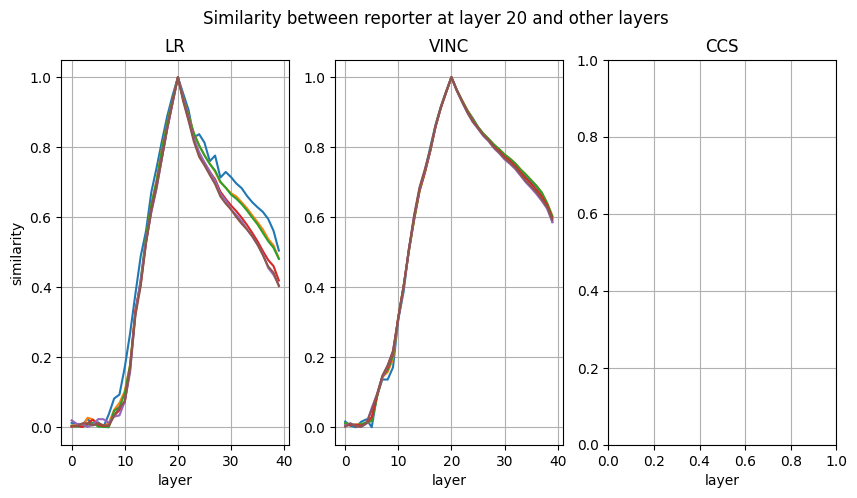

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))

# Set big title for the whole figure
fig.suptitle("Similarity between reporter at layer 20 and other layers")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label=f"range  {d}")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in d_array:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label=f"range  {d}")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [1,5,10]:
    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label=f"range   {d}")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


KeyError: ('arith1', 'ccs-vinc')

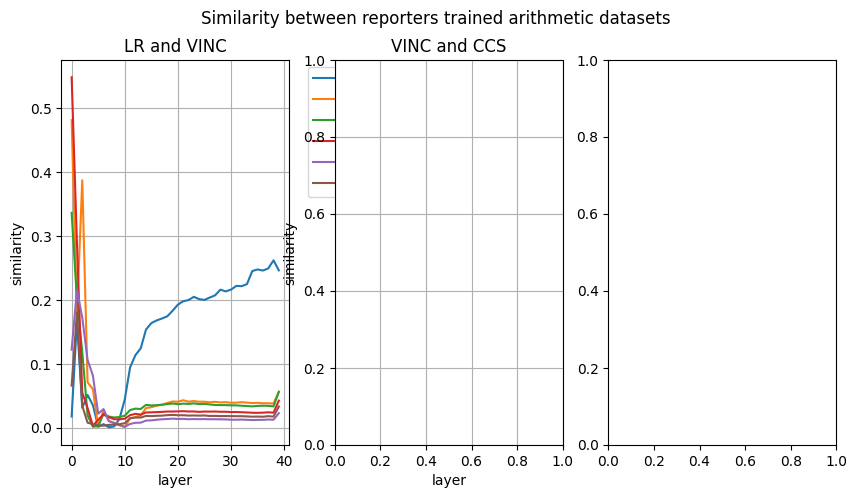

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))

# Set big title for the whole figure
fig.suptitle("Similarity between reporters trained arithmetic datasets")

ax = axs[0]
ax.set_title(fr"LR and VINC")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-vinc')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[1]
ax.set_title(fr"VINC and CCS")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = f" range{d}")



KeyError: ('arith5', 'ccs-1-5')

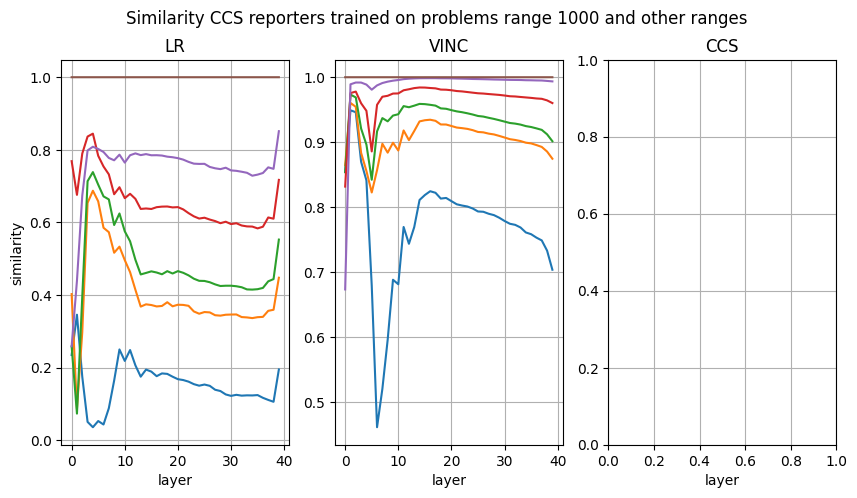

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))

# Set big title for the whole figure
fig.suptitle("Similarity CCS reporters trained on problems range 1000 and other ranges")

ax = axs[0]
ax.set_title(fr"LR")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-1-{d}')]), label = f" range{d}")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[1]
ax.set_title(fr"VINC")
ax.set_xlabel("layer")
ax.grid(True)

for d in d_array:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-1-{d}')]), label = f" range{d}")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax = axs[2]
ax.set_title(fr"CCS")
ax.set_xlabel("layer")
ax.grid(True)

for d in [5,10]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-1-{d}')]), label = f" range{d}")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Ungrouped

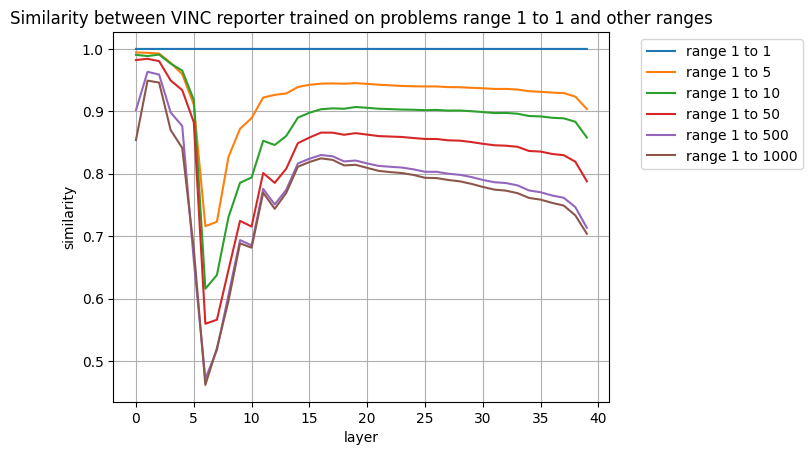

In [23]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter trained on problems range 1000 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-1-{d}')]), label = f" range{d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

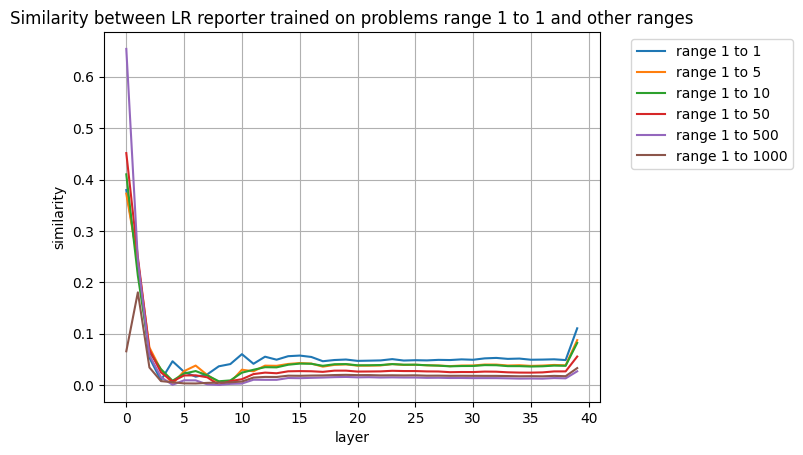

In [24]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR reporter trained on problems range 1000 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-1-{d}')]), label = f" range{d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

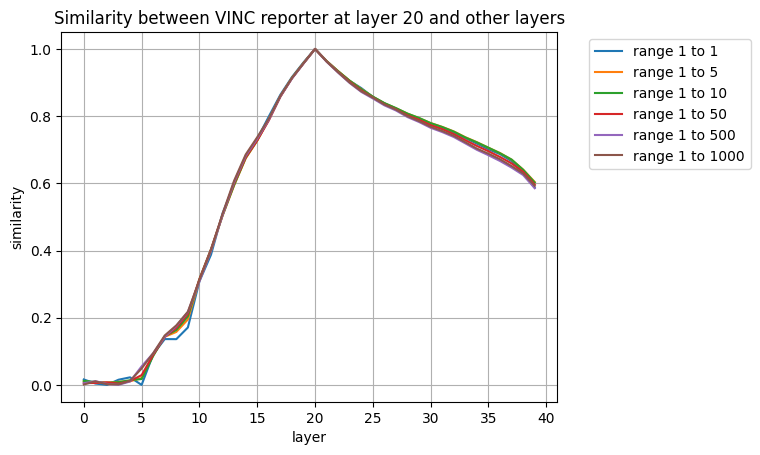

In [21]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between VINC reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'vinc-{d}-layer20')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

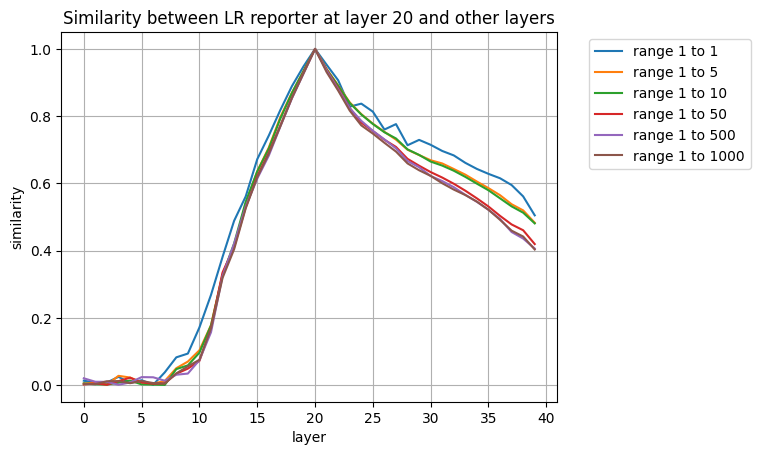

In [25]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between LR reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'lr-{d}-layer20')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

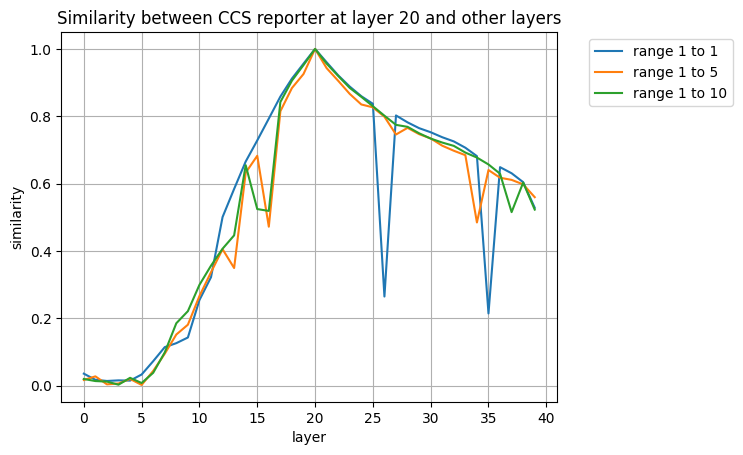

In [35]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between CCS reporter at layer 20 and other layers")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f'arith{d}'
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-{d}-layer20')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

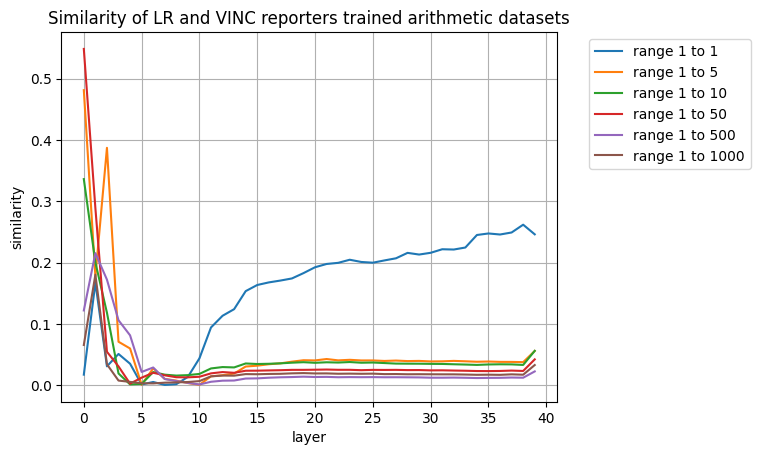

In [26]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity of LR and VINC reporters trained arithmetic datasets")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in d_array:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'lr-vinc')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

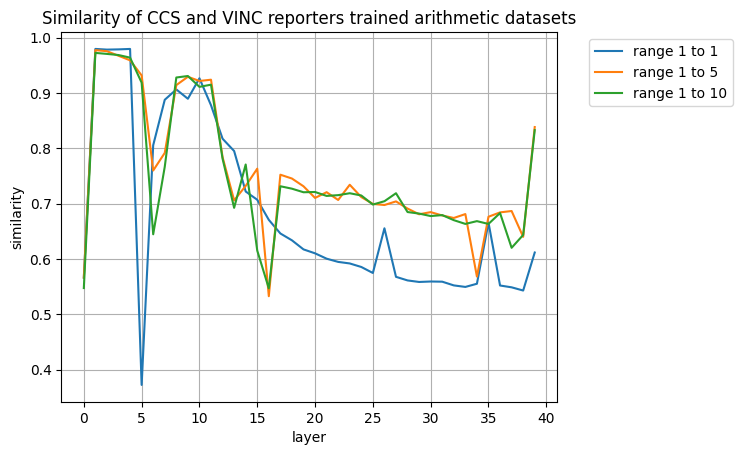

In [21]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity of CCS and VINC reporters trained arithmetic datasets")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [1,5,10]:

    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, 'ccs-vinc')]), label = f" range{d}")

                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

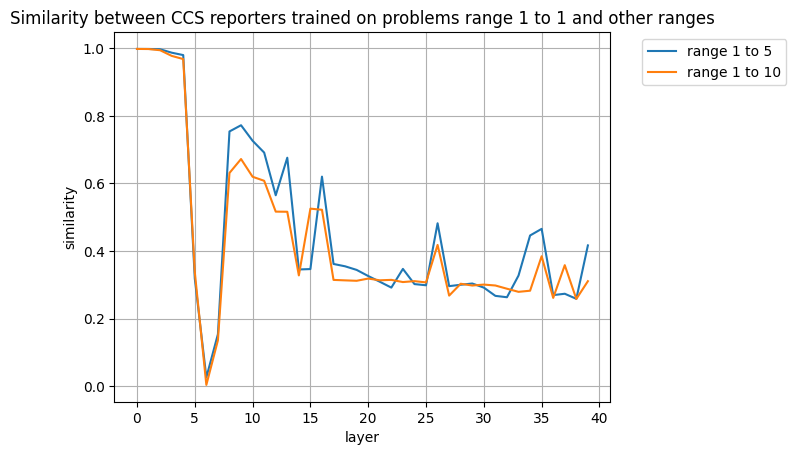

In [36]:
fig, ax = plt.subplots()
ax.set_title(fr"Similarity between CCS reporters trained on problems range 1 and other ranges")
ax.set_xlabel("layer")
ax.set_ylabel("similarity")
ax.grid(True)

for d in [5,10]:
    dataset = f"arith{d}"
    ax.plot(layers_arr, np.absolute(sim[(dataset, f'ccs-1-{d}')]), label = f" range{d}")
                
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()